In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/Project/deap")

In [ ]:
#username: evshuranov@itmo.ru
#password: ljli0Nyj

In [ ]:
#!wget --user evshuranov@itmo.ru --password ljli0Nyj http://www.eecs.qmul.ac.uk/mmv/datasets/deap/data/metadata_csv.zip

In [ ]:
#!wget --user evshuranov@itmo.ru --password ljli0Nyj  "http://www.eecs.qmul.ac.uk/mmv/datasets/deap/data/data_preprocessed_python.zip" 


In [ ]:
#!unzip  data_preprocessed_python.zip -d .


In [ ]:
#import _pickle as cPickle
#import six
#from six.moves import cPickle as pickle
import pickle
x = pickle.load(open('./data_preprocessed_python/s01.dat', 'rb'), encoding='latin1')

In [ ]:
data = x['data']
labels = x['labels']

In [ ]:
print(data.shape)

(40, 40, 8064)


In [ ]:
print(labels.shape)

(40, 4)


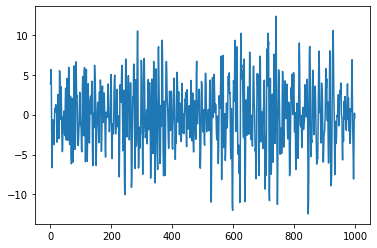

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data[0][0][1500:2500])

In [ ]:
import scipy
from  scipy import signal
freq, power = signal.welch(data[0][0], fs=128.0, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

In [ ]:
print(freq)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5
 56.  56.5 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5
 63.  63.5 64. ]


In [ ]:
print(len(power))

129


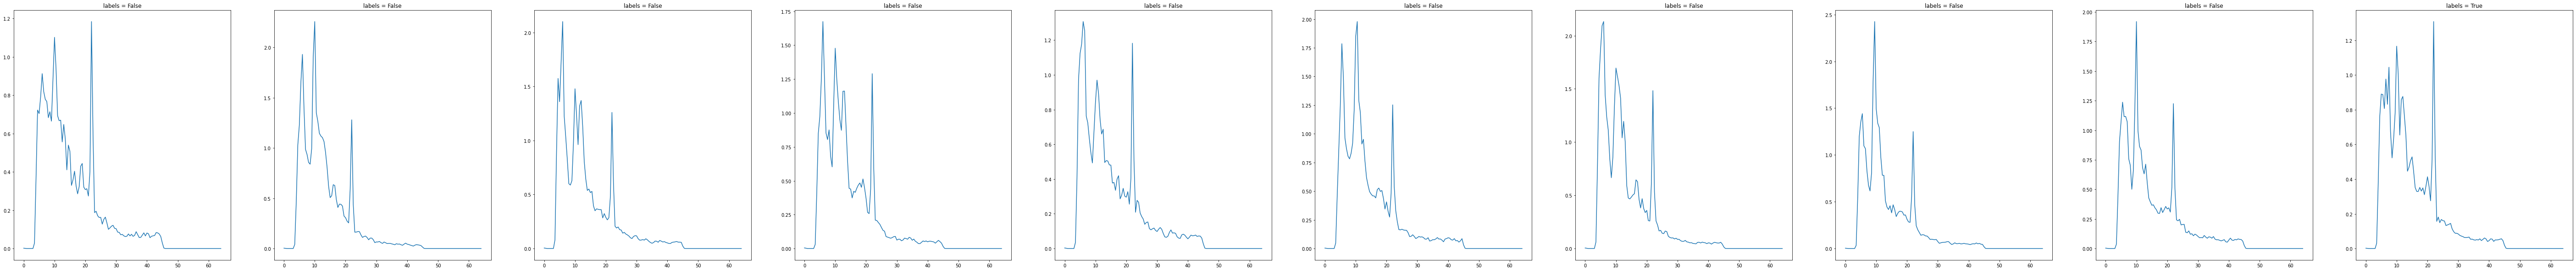

In [ ]:
fig, axes = plt.subplots(1,10, figsize = (100, 10))
A = 30
for i in range(0 + A,10 + A):
    freq, power = signal.welch(data[i][0], fs=128.0, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
    axes[i -A].plot(freq, power)
    axes[i - A].set_title(f'labels = {(labels[i][0] > 4.5)}')

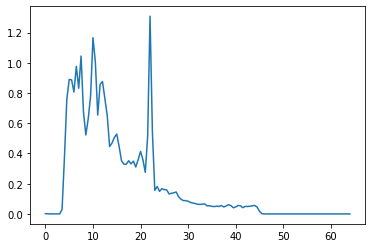

In [ ]:
plt.plot(freq, power)

In [ ]:
#from scipy.fft import fft, ifft

#pre_stimul = fft(data[0][0][0:128 * 3])

The logarithms of the spectral power from
theta (4-8 Hz), slow alpha (8-10 Hz), alpha (8-12 Hz), beta
(12-30Hz) and gamma (30+ Hz) bands were extracted
from all 32 electrodes as features. In addition to power
spectral features the difference between the spectral
power of all the symmetrical pairs of electrodes on
the right and left hemisphere was extracted to measure
the possible asymmetry in the brain activities due to
emotional stimuli. The total number of EEG features of
a trial for 32 electrodes is 216.

In [ ]:
freq_ranges = [range(4,9), range(8,11), range(8,13), range(12, 31), range(30,48)]
pairs_canals = [[1, 17], [2, 18], [3, 20], [4, 21], [5, 22], [6, 23], [7, 25], [8, 26], [9, 27], [10, 28], [11, 29], [12, 30], [12, 31], [13, 32]]

In [ ]:
import numpy as np
freq_resolution = max(freq)/(len(freq) - 1)
max_freq = 128
NVIDEOS = 40
NCANALS = 32
def get_features(data, labels, freq_resolution, max_freq):
  data_for_videos = []
  for id in range(NVIDEOS):
    data_for_one_video = []
    for i in range(NCANALS):
        
        freq, power = scipy.signal.welch(data[id][i], fs=max_freq, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
        #one_canal = []
        for interval in freq_ranges:
            ar = np.asarray(interval)
            ar = (ar / freq_resolution).astype(int)
            power_range = power[ar]
            mean_power = (power_range ** 2).sum()#/len(power_range)
            data_for_one_video.extend([mean_power])
    for pair in pairs_canals:
        canal_1 = pair[0] - 1
        canal_2 = pair[1] - 1
        temp = np.asarray(data_for_one_video[canal_1 * 4 : canal_1 * 4 + 5]) -  np.asarray(data_for_one_video[canal_2 * 4 : canal_2 * 4 + 5])
        data_for_one_video.extend(temp[[0, 2, 3, 4]].tolist())       
        #data_for_one_video.append(one_canal)    
    for s in range(4 * NCANALS):
      data_for_one_video[s] = np.log(data_for_one_video[s])

    temp = np.asarray(data_for_one_video)
    data_for_videos.append(temp)    
  return np.asarray(data_for_videos)     



In [ ]:
print(freq_resolution)

0.5


In [ ]:
data_for_videos = get_features(data, labels, freq_resolution, max_freq)

In [ ]:
print(data_for_videos.shape)

(40, 216)


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,StratifiedKFold


#define predictor and response variables
X = data_for_videos
y = [1 if l > 4.5 else 0 for l in labels[:, 0]]
print(y)
print(X)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[[ 1.63968642  0.89089803  1.35514441 ...  7.58042504  0.22996682
  10.00447528]
 [ 2.14991956  1.33982241  1.69387658 ... 19.12271766 -1.20068419
   9.82386021]
 [ 1.98083448  1.24859921  1.78600385 ... 18.3373592   6.4050124
  20.3155228 ]
 ...
 [ 1.48211931  1.76288804  2.09339062 ...  5.72494305 18.4256837
  31.83203867]
 [ 1.44180075  1.52874276  1.76187868 ...  2.40826406  3.5190315
  11.37524816]
 [ 1.00338209  0.79328575  1.22564589 ...  1.28975576  1.41400401
   6.7157558 ]]


In [ ]:
import glob
data = []
labels = []
data_dir = './data_preprocessed_python'
files = glob.glob(os.path.join(data_dir, "*.dat"))

for file_data in files:
    raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
    data.append(raw_data['data'])
    labels.append(raw_data['labels'])

In [ ]:
data_for_videos = []
for i in  range(len(data)):
    data_for_videos.append(get_features(data[i], labels[i], freq_resolution, max_freq))


In [ ]:
data_all = np.vstack(data_for_videos)
print(data_all.shape)
labels_all = np.vstack(labels)
print(labels_all.shape)

(1280, 216)
(1280, 4)


In [ ]:
labels_all = (labels_all > 4.5)
print(labels_all.shape)


(1280, 4)


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Y =  pca.fit_transform(data_all)


In [ ]:
mask = ((labels_all[:, 0] == 1))
print(len(mask))

1280


In [ ]:
print(Y.shape)

(1280, 2)


In [ ]:
Y_arousal = Y[mask == True]
print(Y_arousal.shape)

(808, 2)


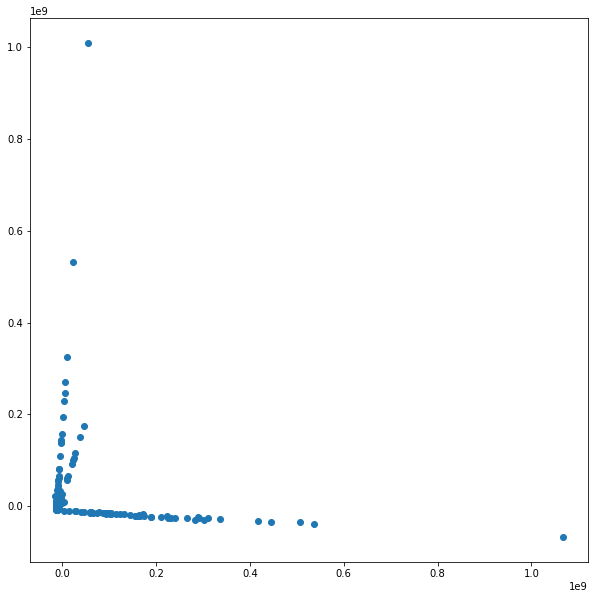

In [ ]:
fig, axes = plt.subplots(figsize = (10, 10))
axes.scatter(Y_arousal[:,0], Y_arousal[:, 1])

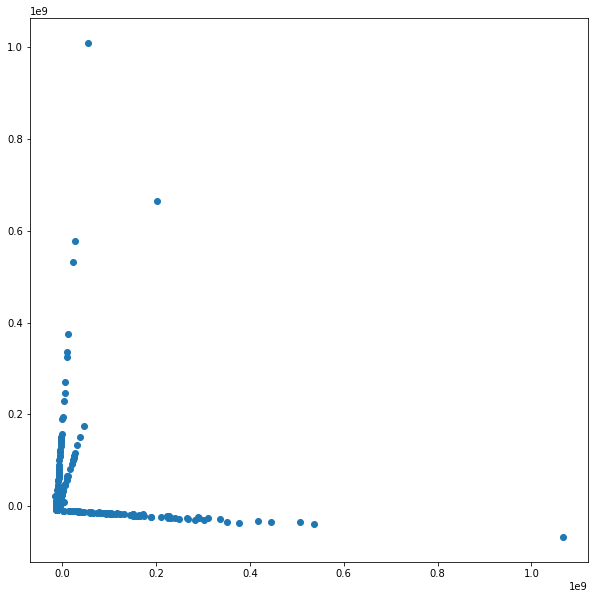

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(figsize = (10, 10))
axes.scatter(Y[:,0], Y[:, 1])

(816, 2)


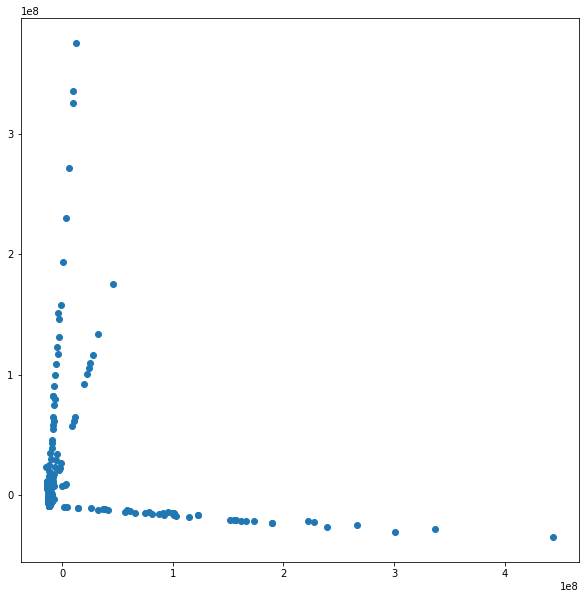

In [ ]:
mask = (labels_all[:, 1] == 1)
Y_valence = Y[mask]
print(Y_valence.shape)
fig, axes = plt.subplots(figsize = (10, 10))
axes.scatter(Y_valence[:,0], Y_valence[:, 1])

In [ ]:
print((([i for i in range(1280) if (Y[i, 1] > 0)])))

[57, 120, 121, 122, 123, 124, 126, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 151, 152, 153, 154, 155, 156, 157, 159, 322, 323, 324, 326, 327, 331, 332, 333, 334, 335, 336, 338, 339, 340, 341, 342, 343, 344, 346, 348, 350, 353, 354, 356, 357, 358, 359, 524, 531, 536, 539, 558, 559, 682, 695, 747, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 929, 936, 937, 938, 939, 940, 941, 942, 946, 948, 949, 968, 976, 997, 1004, 1005, 1007, 1008, 1010, 1011, 1012, 1016, 1021, 1026, 1027, 1032, 1036]


In [ ]:
print(Y.shape)

(1280, 2)


(1143, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


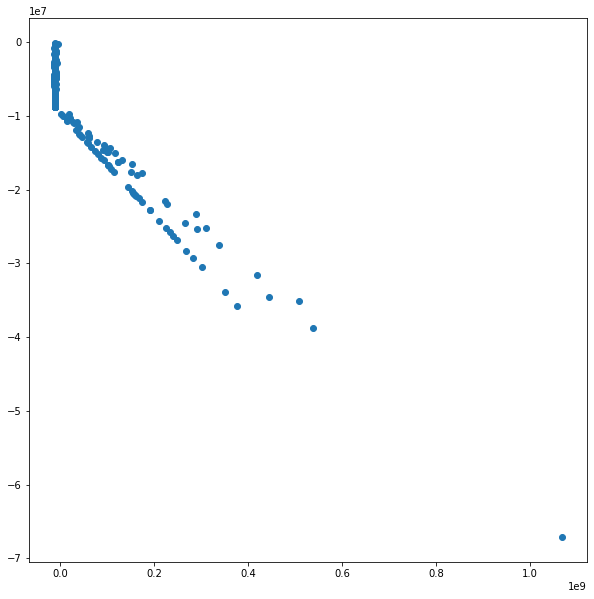

In [ ]:

mask = [(Y[:, 1] < 0)]
Y_neg = Y[mask]
print(Y_neg.shape)
fig, axes = plt.subplots(figsize = (10, 10))
axes.scatter(Y_neg[:,0], Y_neg[:, 1])

In [ ]:
print((([i for i in range(1280) if (Y[i, 1] < -10000000)])))

[400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 640, 641, 642, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 676, 677, 678, 679]


(77, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


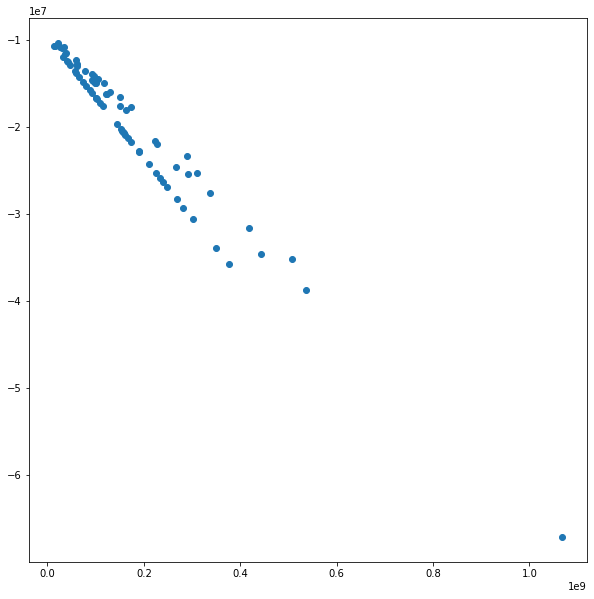

In [ ]:
mask = [(Y[:, 1] < -10000000)]
Y_neg = Y[mask]
print(Y_neg.shape)
fig, axes = plt.subplots(figsize = (10, 10))
axes.scatter(Y_neg[:,0], Y_neg[:, 1])

(1066, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


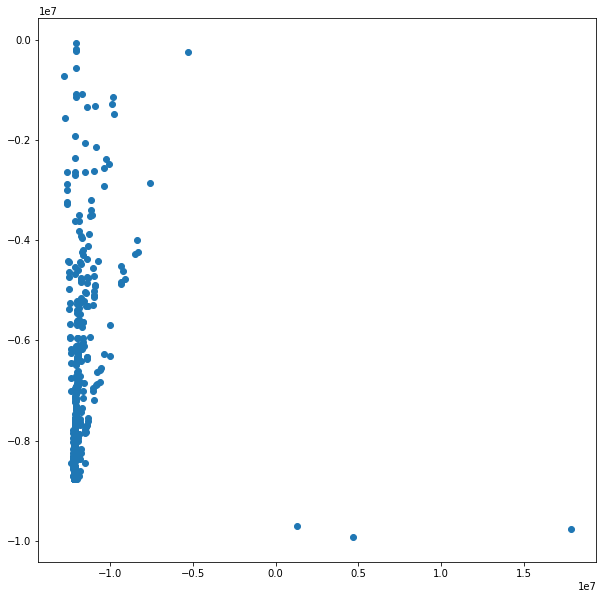

In [ ]:
mask = [(Y[:, 1] > -10000000) & (Y[:, 1] < 0) ]
Y_neg = Y[mask]
print(Y_neg.shape)
fig, axes = plt.subplots(figsize = (10, 10))
axes.scatter(Y_neg[:,0], Y_neg[:, 1])

(137, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


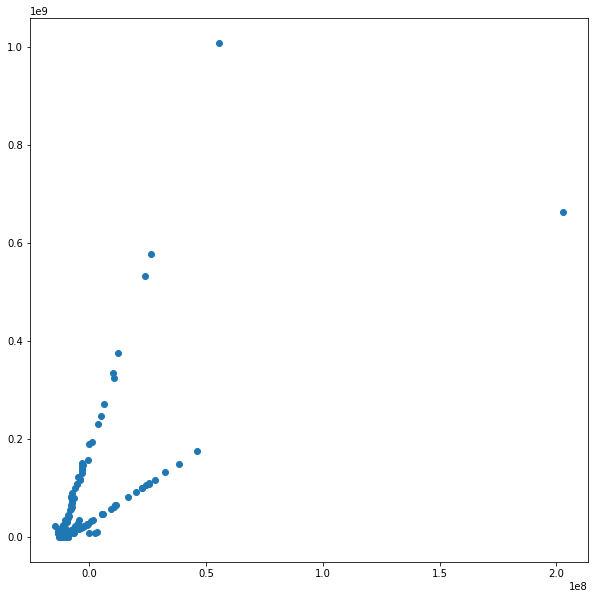

In [ ]:

mask = [(Y[:, 1] > 0)]
Y_pos = Y[mask]
print(Y_pos.shape)
fig, axes = plt.subplots(figsize = (10, 10))
axes.scatter(Y_pos[:,0], Y_pos[:, 1])

In [ ]:
print(mask)

[array([False, False, False, ..., False, False, False])]


In [ ]:
data_for_videos_1 = []
for i in  range(len(data)):
    data_for_videos_1.append(get_features(data[i], labels[i], freq_resolution, max_freq)[0,:])

(32, 216)


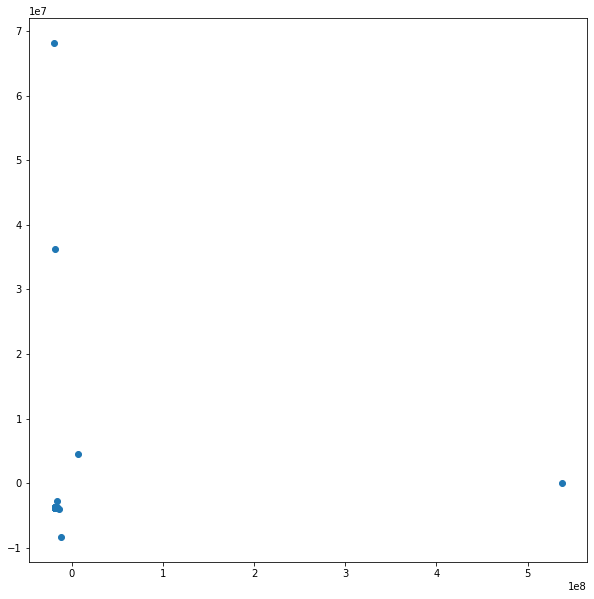

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

data_all_1 = np.vstack(data_for_videos_1)
print(data_all_1.shape)
pca = PCA(n_components=2)
Y =  pca.fit_transform(data_all_1)
from matplotlib import pyplot as plt
fig, axes = plt.subplots(figsize = (10, 10))
axes.scatter(Y[:,0], Y[:, 1])

In [ ]:
data_for_videos_sum = []
for i in  range(len(data)):
    data_for_videos_sum.append(np.sum(data_for_videos[i], axis = 0))

(32, 216)


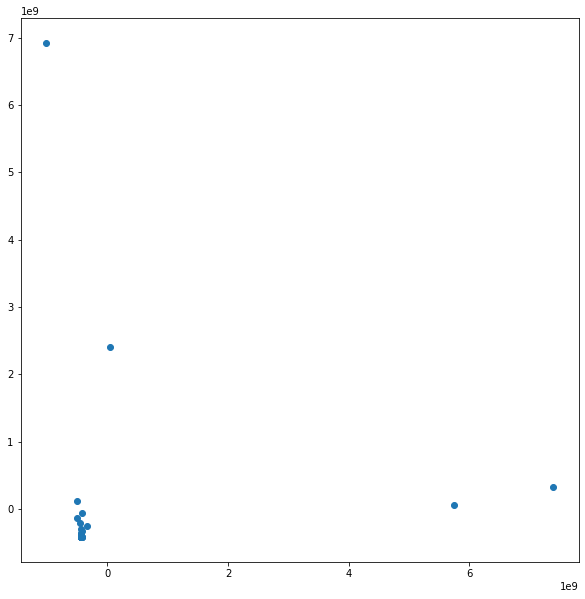

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

data_all_sum = np.vstack(data_for_videos_sum)
print(data_all_sum.shape)
pca = PCA(n_components=2)
Y =  pca.fit_transform(data_all_sum)
from matplotlib import pyplot as plt
fig, axes = plt.subplots(figsize = (10, 10))
axes.scatter(Y[:,0], Y[:, 1])

In [ ]:
print([i for i in range(32) if (Y[i, 0] > 2000000000)])

[10, 16]


In [ ]:
print([i for i in range(32) if(Y[i, 1] > 2000000000)])

[3, 21]


In [ ]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate = 100)
transformed = model.fit_transform(data_all_sum)

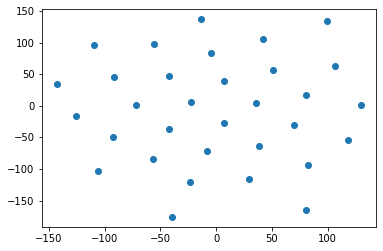

In [ ]:
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis)

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate = 100)
transformed = model.fit_transform(data_all)

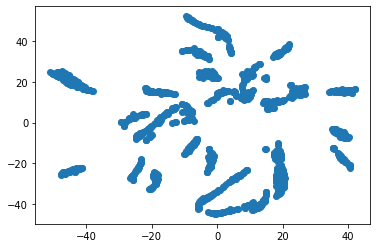

In [ ]:
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis)

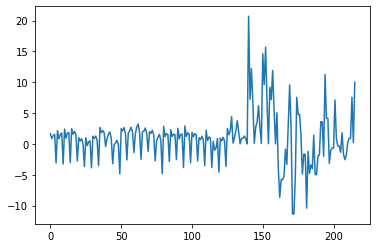

In [ ]:
plt.plot(data_for_videos[0][0])

In [ ]:
print(data_for_videos_sum[0].shape)

(216,)


In [ ]:
def process_lca(X, labels, threshold):
  #mask = (labels == 1)
  #print(mask)
  
  X_pos = X[np.array(labels) == 1]# np.asarray([X[i, :] for i in range(NVIDEOS) if labels[i] == 1])
  X_neg = X[np.array(labels) == 0] #np.asarray([X[i, :] for i in range(NVIDEOS) if labels[i] == 0])
  print(X_pos.shape)
  print(X_neg.shape)
  ##[X[i, :] if labels[i] == 1 for i in range(NVIDEOS)]
  M1 = np.mean(X_pos, axis = 0)
  M2 = np.mean(X_neg, axis = 0)
  SIG1 = np.std(X_pos, axis = 0)
  SIG2 = np.std(X_neg, axis = 0)
  D = abs(M1 - M2)/(SIG1 ** 2 + SIG2 ** 2)
  mask =(D > threshold)
  result = X[:, mask]
  return result


In [ ]:
print(X.shape)

(40, 216)


In [ ]:
X = data_for_videos[0]
y_valence = [1 if l > 4.5 else 0 for l in labels[0][:, 0]]

D = process_lca(X, y_valence, 0.3)
print(D)

(20, 216)
(20, 216)
[[0.89089803 1.35514441 0.47303113 ... 0.10071869 0.04524947 0.02901509]
 [1.33982241 1.69387658 0.94496449 ... 0.09202268 0.04243609 0.04178218]
 [1.24859921 1.78600385 0.88759955 ... 0.09798277 0.05868694 0.06233289]
 ...
 [1.76288804 2.09339062 0.93973946 ... 0.08716815 0.04842285 0.04733101]
 [1.52874276 1.76187868 0.79953049 ... 0.20361025 0.06676531 0.02225318]
 [0.79328575 1.22564589 0.18155212 ... 0.18554773 0.06246127 0.02473123]]


In [ ]:
X[np.array(y_valence) == 0]

array([[  2.53721577,   1.4646431 ,   2.29996644, ...,  63.24210146,
          9.17541122,  24.19504139],
       [  1.74161682,   1.35675513,   1.80743421, ...,  11.58096678,
         11.99724515,  24.44623683],
       [  2.0089701 ,   1.35606536,   1.86258511, ...,  31.82569611,
          9.84964515,  22.61832886],
       ...,
       [  2.38796256,   1.46384154,   2.04733161, ...,  18.673133  ,
        -13.47640058,  13.54365484],
       [  1.48211931,   1.76288804,   2.09339062, ...,   5.72494305,
         18.4256837 ,  31.83203867],
       [  1.44180075,   1.52874276,   1.76187868, ...,   2.40826406,
          3.5190315 ,  11.37524816]])

In [ ]:
import pickle

from sklearn.model_selection import cross_val_score
#define cross-validation method to use
#cv = StratifiedKFold(n_splits=8, random_state=1, shuffle=True)
cv = KFold(n_splits=8, random_state=1, shuffle=True)


acc_valence_all = []
f1_valence_all = []
acc_arousal_all = []
f1_arousal_all = []
acc_like_all = []
f1_like_all = []
for i in  range(len(data)):
    print(i)
    #data_for_videos = get_features(data[i], labels[i], freq_resolution, max_freq)
    X = data_for_videos[i]
    
    y_valence = [1 if l > 4.5 else 0 for l in labels[i][:, 0]]
    y_arousal = [1 if l > 4.5 else 0 for l in labels[i][:, 1]]
    y_like = [1 if l > 4.5 else 0 for l in labels[i][:, 3]]
    X = process_lca(X, y_valence)
    model = GaussianNB()
    #use k-fold CV to evaluate model
    scores_f1 = cross_val_score(model, X, y_valence, cv=cv, scoring = 'f1', n_jobs=-1)
    f1_valence_all.append(np.mean(scores_f1))
    scores_acc = cross_val_score(model, X, y_valence, cv=cv, scoring = 'accuracy', n_jobs=-1)
    acc_valence_all.append(np.mean(scores_acc))
    model = GaussianNB()
    #use k-fold CV to evaluate model
    scores_f1 = cross_val_score(model, X, y_arousal, cv=cv, scoring = 'f1', n_jobs=-1)
    f1_arousal_all.append(np.mean(scores_f1))
    scores_acc = cross_val_score(model, X, y_arousal, cv=cv, scoring = 'accuracy', n_jobs=-1)
    acc_arousal_all.append(np.mean(scores_acc))
    
    model = GaussianNB()
    #use k-fold CV to evaluate model
    scores_f1 = cross_val_score(model, X, y_like, cv=cv, scoring = 'f1', n_jobs=-1)
    f1_like_all.append(np.mean(scores_f1))
    scores_acc = cross_val_score(model, X, y_like, cv=cv, scoring = 'accuracy', n_jobs=-1)
    acc_like_all.append(np.mean(scores_acc))
    


0


TypeError: ignored

In [ ]:
from sklearn import metrics
print(sorted(metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


Метрики с полным набором фич. Без применения отбора фич методом LDA

0.6281249999999999
0.6213882688492063


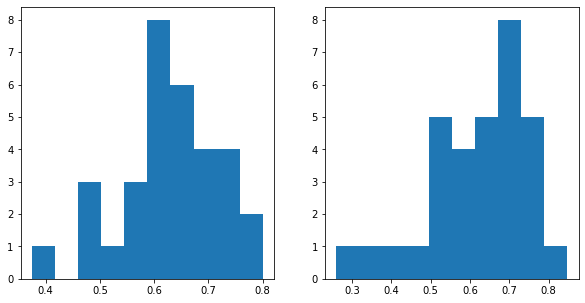

In [ ]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].hist(acc_valence_all)
axes[1].hist(f1_valence_all)
print(np.mean(acc_valence_all))
print(np.mean(f1_valence_all))


0.5765625000000001
0.5887586805555556


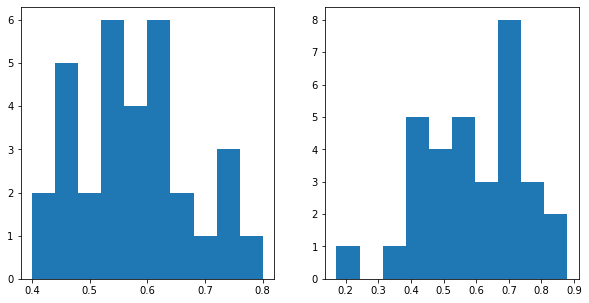

In [ ]:
fig,axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].hist(acc_arousal_all)
axes[1].hist(f1_arousal_all)
print(np.mean(acc_arousal_all))
print(np.mean(f1_arousal_all))


0.6156250000000001
0.6458860367063493


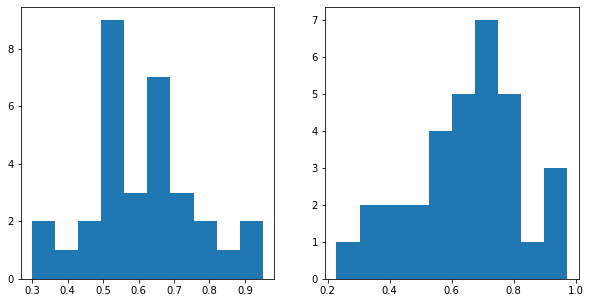

In [ ]:
fig,axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].hist(acc_like_all)
axes[1].hist(f1_like_all)
print(np.mean(acc_like_all))
print(np.mean(f1_like_all))


Добавляю отбор фич методом LDA ( с порогом 0.3)

In [ ]:
import pickle

from sklearn.model_selection import cross_val_score
#define cross-validation method to use
#cv = StratifiedKFold(n_splits=8, random_state=1, shuffle=True)
cv = KFold(n_splits=8, random_state=1, shuffle=True)


acc_valence_all = []
f1_valence_all = []
acc_arousal_all = []
f1_arousal_all = []
acc_like_all = []
f1_like_all = []
for i in  range(len(data)):
    print(i)
    #data_for_videos = get_features(data[i], labels[i], freq_resolution, max_freq)
    X = data_for_videos[i]
    X_valence = process_lca(X, y_valence, 0.3)
    X_arousal = process_lca(X, y_valence, 0.3)
    X_like = process_lca(X, y_valence, 0.3)
    y_valence = [1 if l > 4.5 else 0 for l in labels[i][:, 0]]
    y_arousal = [1 if l > 4.5 else 0 for l in labels[i][:, 1]]
    y_like = [1 if l > 4.5 else 0 for l in labels[i][:, 3]]
    model = GaussianNB()
    #use k-fold CV to evaluate model
    scores_f1 = cross_val_score(model, X_valence, y_valence, cv=cv, scoring = 'f1', n_jobs=-1)
    f1_valence_all.append(np.mean(scores_f1))
    scores_acc = cross_val_score(model, X_valence, y_valence, cv=cv, scoring = 'accuracy', n_jobs=-1)
    acc_valence_all.append(np.mean(scores_acc))
    model = GaussianNB()
    #use k-fold CV to evaluate model
    scores_f1 = cross_val_score(model, X_arousal, y_arousal, cv=cv, scoring = 'f1', n_jobs=-1)
    f1_arousal_all.append(np.mean(scores_f1))
    scores_acc = cross_val_score(model, X_arousal, y_arousal, cv=cv, scoring = 'accuracy', n_jobs=-1)
    acc_arousal_all.append(np.mean(scores_acc))
    
    model = GaussianNB()
    #use k-fold CV to evaluate model
    scores_f1 = cross_val_score(model, X_like, y_like, cv=cv, scoring = 'f1', n_jobs=-1)
    f1_like_all.append(np.mean(scores_f1))
    scores_acc = cross_val_score(model, X_like, y_like, cv=cv, scoring = 'accuracy', n_jobs=-1)
    acc_like_all.append(np.mean(scores_acc))

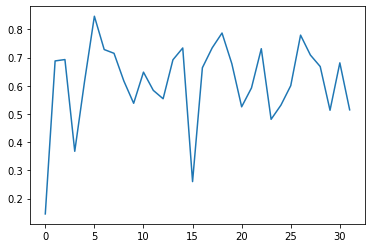

In [ ]:
plt.plot(f1_valence_all)
#plt.plot(acc_valence_all)

In [ ]:
print([i for i in range(32) if (f1_valence_all[i] < 0.4)])

[0, 3, 15]


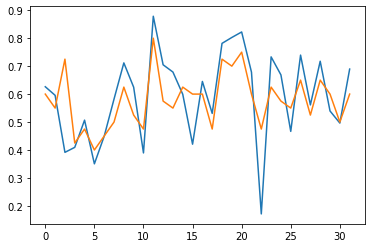

In [ ]:
plt.plot(f1_arousal_all)
plt.plot(acc_arousal_all)


In [ ]:
print([i for i in range(32) if (f1_arousal_all[i] < 0.4)])

[2, 5, 10, 22]


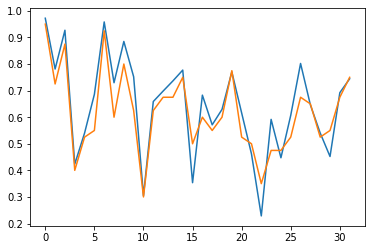

In [ ]:
plt.plot(f1_like_all)
plt.plot(acc_like_all)

In [ ]:
print([i for i in range(32) if (f1_like_all[i] < 0.4)])

[10, 15, 22]


In [ ]:
import pandas as pd
result = pd.DataFrame(columns = ['arousal', 'valence', 'like'], index = ['accuracy', 'f1'])

0.6234375
0.6132967509920635


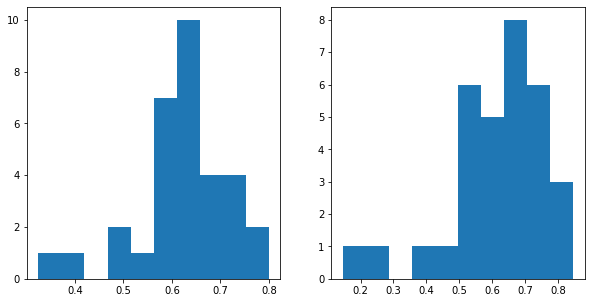

In [ ]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].hist(acc_valence_all)
axes[1].hist(f1_valence_all)
print(np.mean(acc_valence_all))
print(np.mean(f1_valence_all))
result.loc['accuracy', 'valence'] = np.mean(acc_valence_all)
result.loc['f1', 'valence'] = np.mean(f1_valence_all)

0.578125
0.5926649305555556


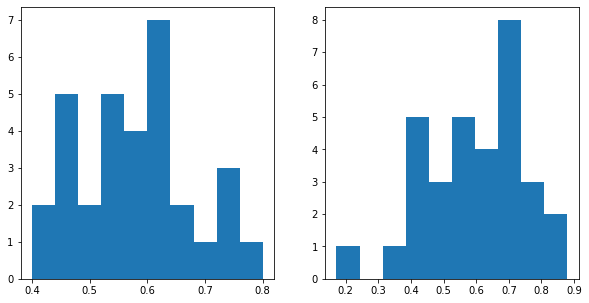

In [ ]:
fig,axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].hist(acc_arousal_all)
axes[1].hist(f1_arousal_all)
print(np.mean(acc_arousal_all))
print(np.mean(f1_arousal_all))
result.loc['accuracy', 'arousal'] = np.mean(acc_arousal_all)
result.loc['f1', 'arousal'] = np.mean(f1_arousal_all)

0.6156250000000001
0.6458860367063493


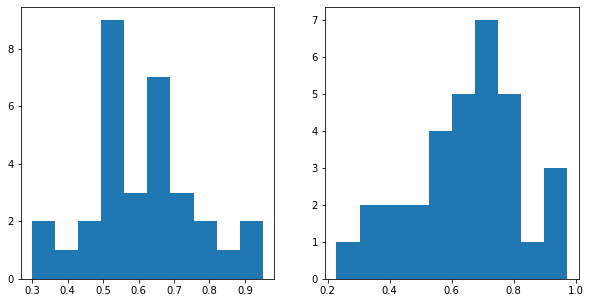

In [ ]:
fig,axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].hist(acc_like_all)
axes[1].hist(f1_like_all)
print(np.mean(acc_like_all))
print(np.mean(f1_like_all))
result.loc['accuracy', 'like'] = np.mean(acc_like_all)
result.loc['f1', 'like'] = np.mean(f1_like_all)

In [ ]:
print(result)

           arousal   valence      like
accuracy  0.578125  0.623437  0.615625
f1        0.592665  0.613297  0.645886
